In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os

# --- 1. Configuration (配置层) ---
DATA_CONFIG = {
    'files': {
        'info': 'paper_information.csv',
        'edges': 'paper_edge_citation.csv',
        'crawled': 'crawled_details.csv'  # 爬虫获取的补充数据
    },
    'journal_mapping': {
        'JOURNAL OF THE AMERICAN STATISTICAL ASSOCIATION': 'JASA',
        'BIOMETRIKA': 'Biometrika',
        'JOURNAL OF THE ROYAL STATISTICAL SOCIETY SERIES B-STATISTICAL METHODOLOGY': 'J. R. Stat. Soc. B',
        'ANNALS OF STATISTICS': 'Ann. Stat'
    }
}

In [7]:
# --- 2. Functional Core (逻辑层) ---

def clean_doi(doi):
    """Standardize DOI format by removing prefixes for accurate merging."""
    if pd.isna(doi):
        return None
    # Remove common prefixes to get the clean ID
    return str(doi).replace('https://doi.org/', '').strip()

def load_and_process_data(config):
    """
    Loads raw data, merges with crawled year info, cleans missing values, 
    and constructs the citation graph.
    """
    print("⏳ Loading datasets...")
    
    # 1. Load Raw Data
    if not os.path.exists(config['files']['info']) or not os.path.exists(config['files']['edges']):
        raise FileNotFoundError("Base data files (info/edges) not found.")
        
    paper_info = pd.read_csv(config['files']['info'])
    edges = pd.read_csv(config['files']['edges'])
    
    # 2. Load Crawled Data (for Year completion)
    try:
        crawled_data = pd.read_csv(config['files']['crawled'])
        print(f"   Loaded {len(crawled_data)} crawled records for enrichment.")
    except FileNotFoundError:
        print("   Warning: Crawled data file not found. Proceeding with raw data only (Years might be missing).")
        crawled_data = pd.DataFrame(columns=['doi', 'year'])

    # 3. Data Cleaning & Merging
    print("🧹 Cleaning and Merging...")
    # Standardize DOIs for merging key
    paper_info['clean_doi'] = paper_info['doi'].apply(clean_doi)
    crawled_data['clean_doi'] = crawled_data['doi'].apply(clean_doi)
    
    # Merge to get 'year'. We use 'left' join to keep all original papers initially.
    # Note: crawled_details.csv usually has columns like ['doi', 'year', ...]
    merged_df = paper_info.merge(crawled_data[['clean_doi', 'year']], on='clean_doi', how='left', suffixes=('', '_crawled'))
    
    # Consolidate Year: Robust logic to handle cases where paper_info might or might not have 'year'
    if 'year_crawled' in merged_df.columns:
        # Collision happened: prioritize crawled year, fill with original year if missing
        merged_df['year'] = merged_df['year_crawled'].fillna(merged_df['year'])
    elif 'year' not in merged_df.columns:
        # No year column at all (unlikely if crawled data loaded correctly)
        merged_df['year'] = np.nan
    # Else: 'year' exists and 'year_crawled' does not. 
    # This means the 'year' column comes from crawled_data (if paper_info lacked it) 
    # or paper_info (if crawled_data lacked it). In either case, we are good.
        
    # Filter A: Must have a valid year (Crucial for Temporal Link Prediction)
    merged_df['year'] = pd.to_numeric(merged_df['year'], errors='coerce')
    valid_year_mask = merged_df['year'].notna() & (merged_df['year'] > 1900) & (merged_df['year'] <= 2025)
    
    # Filter B: Target Journals Only (Big 4)
    target_journals = config['journal_mapping'].keys()
    journal_mask = merged_df['publisher'].isin(target_journals)
    
    # Apply Filters
    clean_info = merged_df[valid_year_mask & journal_mask].copy()
    clean_info['publisher'] = clean_info['publisher'].replace(config['journal_mapping'])
    
    # 4. Construct Citation Network
    print("🕸️ Constructing Citation Network...")
    valid_ids = set(clean_info['paper_id'])
    
    # Filter edges: Both source and target must be in our valid paper list (Internal Citation Network)
    valid_edges = edges[
        edges['source'].isin(valid_ids) & 
        edges['target'].isin(valid_ids)
    ].copy()
    
    # Build Graph using NetworkX
    G = nx.from_pandas_edgelist(
        valid_edges,
        source='source',
        target='target',
        create_using=nx.DiGraph()
    )
    
    # Add node attributes (year, journal, title) to the graph for easy access later
    # This is important for feature engineering (e.g., time gap, journal distance)
    node_attrs = clean_info.set_index('paper_id')[['year', 'publisher', 'title']].to_dict('index')
    nx.set_node_attributes(G, node_attrs)
    
    # Report
    print("\n📊 Data Integration Report")
    print("=" * 40)
    print(f"Original Papers: {len(paper_info)}")
    print(f"Papers with Valid Year & Journal: {len(clean_info)}")
    print(f"Dropped Papers (Missing Year/Non-Big4): {len(paper_info) - len(clean_info)}")
    print("-" * 40)
    print(f"Original Edges: {len(edges)}")
    print(f"Valid Edges (Internal): {len(valid_edges)}")
    print(f"Graph Nodes: {G.number_of_nodes()}")
    print(f"Graph Edges: {G.number_of_edges()}")
    print("=" * 40)
    
    return clean_info, valid_edges, G

In [8]:
# --- 3. Execution (执行层) ---
paper_info, paper_citations, G_full = load_and_process_data(DATA_CONFIG)

# Preview Data
print("\nTop 5 Cleaned Papers:")
display(paper_info[['paper_id', 'title', 'year', 'publisher']].head())

⏳ Loading datasets...
   Loaded 5521 crawled records for enrichment.
🧹 Cleaning and Merging...
🕸️ Constructing Citation Network...

📊 Data Integration Report
Original Papers: 5746
Papers with Valid Year & Journal: 5178
Dropped Papers (Missing Year/Non-Big4): 568
----------------------------------------
Original Edges: 23737
Valid Edges (Internal): 19607
Graph Nodes: 5096
Graph Edges: 19607

Top 5 Cleaned Papers:
   Loaded 5521 crawled records for enrichment.
🧹 Cleaning and Merging...
🕸️ Constructing Citation Network...

📊 Data Integration Report
Original Papers: 5746
Papers with Valid Year & Journal: 5178
Dropped Papers (Missing Year/Non-Big4): 568
----------------------------------------
Original Edges: 23737
Valid Edges (Internal): 19607
Graph Nodes: 5096
Graph Edges: 19607

Top 5 Cleaned Papers:


,paper_id,title,year,publisher
0,1,MERGING AND TESTING OPINIONS,2014.0,Ann. Stat
1,2,EFFICIENT ESTIMATION OF INTEGRATED VOLATILITY ...,2014.0,Ann. Stat
2,3,FURTHER RESULTS ON CONTROLLING THE FALSE DISCO...,2014.0,Ann. Stat
3,4,POSTERIOR CONTRACTION IN SPARSE BAYESIAN FACTO...,2014.0,Ann. Stat
4,5,A REMARK ON THE RATES OF CONVERGENCE FOR INTEG...,2014.0,Ann. Stat


## Phase 1: Temporal Slicing (时序切片)

**目标**:
1.  **探索时间范围**: 统计清洗后数据的年份分布，确定数据集的有效时间跨度。
2.  **划分训练/测试集**: 基于时间分布，选择合理的切分点 ($T_{split}$)。
    *   **Training Graph ($G_{train}$)**: 包含 $T_{start} \sim T_{split}$ 的所有论文及其内部引用。
    *   **Testing Ground Truth**: 包含 $T_{split+1} \sim T_{end}$ 期间产生的新引用关系（用于验证预测结果）。

**方法论**:
> Nature 论文中通常使用滑动窗口或固定时间点切分。为了简化，我们将采用固定时间点切分。
> *   **Snapshot 1 (Train)**: 历史数据构建的基础网络。
> *   **Snapshot 2 (Test)**: 未来发生的连接。

📅 Dataset Time Range: 2001 - 2018


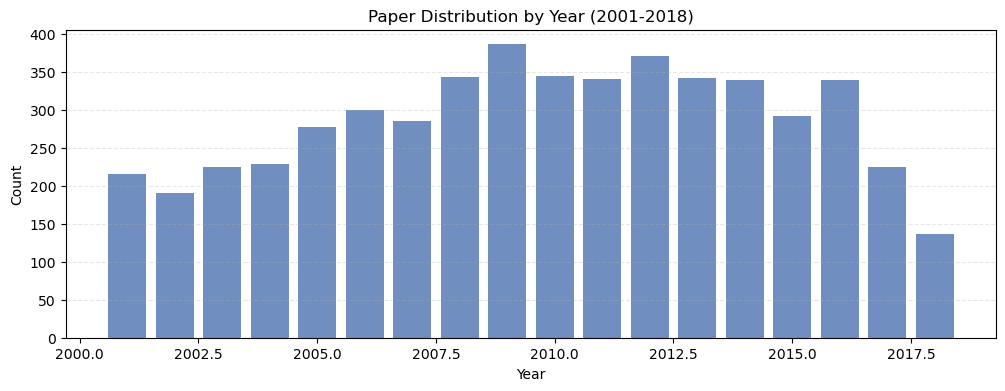

✂️  Determined Split Year: 2015.0 (Targeting ~15% for Test)

📊 Split Results:
   Training Set (<= 2015.0): 4478 papers
   Training Graph: 4403 nodes, 14994 edges
   Test Set (> 2015.0): 700 papers


In [9]:
# --- Phase 1: Temporal Analysis & Slicing ---

def analyze_and_split_data(df, G, test_ratio=0.15):
    """
    Analyzes temporal distribution and splits the graph into Train/Test sets.
    """
    # 1. Temporal Distribution Analysis
    year_counts = df['year'].value_counts().sort_index()
    if year_counts.empty:
        raise ValueError("No valid year data found to split.")

    min_year = int(year_counts.index.min())
    max_year = int(year_counts.index.max())
    
    print(f"📅 Dataset Time Range: {min_year} - {max_year}")
    
    # Visualization
    plt.figure(figsize=(12, 4))
    plt.bar(year_counts.index, year_counts.values, color='#4c72b0', alpha=0.8)
    plt.title(f'Paper Distribution by Year ({min_year}-{max_year})')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.show()
    
    # 2. Determine Split Point (Dynamic)
    # Strategy: Use the (1-test_ratio) percentile of the data as the split point.
    cumulative = year_counts.cumsum()
    total_papers = cumulative.iloc[-1]
    threshold = total_papers * (1 - test_ratio)
    
    # Find the first year where cumulative count exceeds threshold
    split_idx = np.searchsorted(cumulative.values, threshold)
    suggested_split = year_counts.index[split_idx]
    
    # Safety check: Ensure we don't split at the very end if possible
    if suggested_split == max_year and max_year > min_year:
        suggested_split = max_year - 1
        
    print(f"✂️  Determined Split Year: {suggested_split} (Targeting ~{int(test_ratio*100)}% for Test)")
    
    # 3. Create Training Graph (G_train)
    # G_train contains all nodes and edges existing UP TO split_year
    train_mask = df['year'] <= suggested_split
    train_paper_ids = set(df[train_mask]['paper_id'])
    
    G_train = G.subgraph(train_paper_ids).copy()
    
    # 4. Define Test Set Scope
    # Test set includes papers published AFTER split_year
    test_mask = df['year'] > suggested_split
    test_papers = df[test_mask]
    
    print(f"\n📊 Split Results:")
    print(f"   Training Set (<= {suggested_split}): {len(train_paper_ids)} papers")
    print(f"   Training Graph: {G_train.number_of_nodes()} nodes, {G_train.number_of_edges()} edges")
    print(f"   Test Set (> {suggested_split}): {len(test_papers)} papers")
    
    return G_train, test_papers, suggested_split

# Execute Phase 1
# Note: We use paper_info (cleaned) and G_full from the previous step
G_train, test_papers, SPLIT_YEAR = analyze_and_split_data(paper_info, G_full)

## Phase 2: Sample Construction (样本构建)

**目标**:
构建用于监督学习的训练集和测试集。
Link Prediction 本质上是一个二分类问题（存在引用 vs 不存在引用）。

**策略**:
1.  **正样本 (Positive Samples)**:
    *   **Train**: $G_{train}$ 中现有的所有引用边。
    *   **Test**: $T_{split}$ 之后发表的论文对 $G_{train}$ 中论文的引用（Future Links）。
2.  **负样本 (Negative Samples)**:
    *   由于引文网络极其稀疏，我们需要人工构建“不存在的引用”。
    *   **策略**: 随机采样未连接的节点对，保持与正样本 **1:1** 的比例（Balanced Sampling）。

**输出**:
*   `train_samples`: 包含 `source`, `target`, `label` (1/0), `split`='train'
*   `test_samples`: 包含 `source`, `target`, `label` (1/0), `split`='test'

In [10]:
import random
from tqdm import tqdm

# --- Phase 2: Sample Construction ---

def generate_negative_samples(G_ref, positive_pairs, num_negatives, valid_targets=None):
    """
    Generates negative samples (non-edges) for link prediction.
    
    Args:
        G_ref: Reference graph to check for existing edges.
        positive_pairs: List of (u, v) tuples that are positive samples (to avoid).
        num_negatives: Number of negative samples to generate.
        valid_targets: Set of valid target nodes (optional). If None, uses all nodes in G_ref.
    """
    negatives = set()
    nodes = list(G_ref.nodes())
    if valid_targets is None:
        valid_targets = list(G_ref.nodes())
    else:
        valid_targets = list(valid_targets)
        
    # Convert positive pairs to a set for O(1) lookup
    existing_edges = set(positive_pairs)
    
    print(f"   Generating {num_negatives} negative samples...")
    with tqdm(total=num_negatives) as pbar:
        while len(negatives) < num_negatives:
            # Randomly select source and target
            u = random.choice(nodes)
            v = random.choice(valid_targets)
            
            # Conditions for a valid negative sample:
            # 1. u != v (No self-loops)
            # 2. (u, v) is NOT in the graph (No existing edge)
            # 3. (u, v) is NOT already selected as a negative
            if u != v and not G_ref.has_edge(u, v) and (u, v) not in negatives:
                negatives.add((u, v))
                pbar.update(1)
                
    return list(negatives)

def construct_samples(G_full, G_train, test_papers, split_year):
    """
    Constructs balanced Train and Test datasets.
    """
    print("🔨 Constructing Samples...")
    
    # --- 1. Training Set ---
    # Positives: Edges in G_train
    train_pos = list(G_train.edges())
    
    # Negatives: Random non-edges within G_train nodes
    # We sample same amount as positives (1:1 ratio)
    train_neg = generate_negative_samples(
        G_train, 
        train_pos, 
        len(train_pos)
    )
    
    # Create DataFrame
    train_df = pd.DataFrame(train_pos, columns=['source', 'target'])
    train_df['label'] = 1
    
    train_neg_df = pd.DataFrame(train_neg, columns=['source', 'target'])
    train_neg_df['label'] = 0
    
    train_data = pd.concat([train_df, train_neg_df], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
    
    # --- 2. Test Set (Future Prediction) ---
    # Definition: Edges where Source is in Test Set (Future) AND Target is in Train Set (Past)
    # This simulates: "A new paper is published, what existing papers does it cite?"
    
    test_paper_ids = set(test_papers['paper_id'])
    train_paper_ids = set(G_train.nodes())
    
    # Find all edges in G_full that match this criteria
    # Iterate over test papers to find their out-edges
    test_pos = []
    for u in test_paper_ids:
        if G_full.has_node(u):
            # Get neighbors (citations)
            citations = list(G_full.successors(u))
            for v in citations:
                if v in train_paper_ids:
                    test_pos.append((u, v))
    
    # Negatives for Test Set
    # Source must be from Test Papers, Target from Train Papers
    # We create a temporary graph or just pass lists to helper
    # Since helper uses G_ref.nodes(), we need to be careful.
    # Let's do it manually for clarity.
    
    print(f"   Generating {len(test_pos)} negative samples for Test Set...")
    test_neg = set()
    test_paper_list = list(test_paper_ids)
    train_paper_list = list(train_paper_ids)
    
    # Safety check for empty test set
    if not test_pos:
        print("⚠️ Warning: No valid future links found. Test set might be empty.")
    else:
        while len(test_neg) < len(test_pos):
            u = random.choice(test_paper_list)
            v = random.choice(train_paper_list)
            
            # Check if edge exists in REALITY (G_full)
            if not G_full.has_edge(u, v) and (u, v) not in test_neg:
                test_neg.add((u, v))
    
    test_df = pd.DataFrame(test_pos, columns=['source', 'target'])
    test_df['label'] = 1
    
    test_neg_df = pd.DataFrame(list(test_neg), columns=['source', 'target'])
    test_neg_df['label'] = 0
    
    test_data = pd.concat([test_df, test_neg_df], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
    
    print("\n✅ Sample Construction Complete")
    print(f"   Train Samples: {len(train_data)} (Pos: {len(train_pos)}, Neg: {len(train_neg)})")
    print(f"   Test Samples:  {len(test_data)} (Pos: {len(test_pos)}, Neg: {len(test_neg)})")
    
    return train_data, test_data

# Execute Phase 2
train_samples, test_samples = construct_samples(G_full, G_train, test_papers, SPLIT_YEAR)

# Preview
print("\nTrain Samples Head:")
display(train_samples.head())

🔨 Constructing Samples...
   Generating 14994 negative samples...


100%|██████████| 14994/14994 [00:00<00:00, 483697.60it/s]

   Generating 4343 negative samples for Test Set...

✅ Sample Construction Complete
   Train Samples: 29988 (Pos: 14994, Neg: 14994)
   Test Samples:  8686 (Pos: 4343, Neg: 4343)

Train Samples Head:


,source,target,label
0,5802,5459,0
1,4308,1506,1
2,384,932,1
3,5896,5191,1
4,5028,6418,0


## Phase 3: Feature Engineering (特征工程)

**目标**:
将节点对 `(u, v)` 转化为机器学习模型可理解的特征向量。

**挑战**:
*   **Cold Start (冷启动)**: 测试集中的 Source 节点是新发表的论文，它们在训练图 $G_{train}$ 中不存在（Degree=0）。
*   这意味着传统的拓扑特征（如 Common Neighbors, Adamic-Adar）对于新论文几乎失效（均为0）。

**解决方案**:
我们需要构建混合特征，重点关注 **Metadata** 和 **Target Node** 的属性：

1.  **Target Popularity (目标热度)**:
    *   `target_degree`: 被引用论文在训练集中的入度（Rich get richer 效应）。
2.  **Content Similarity (内容相似性)**:
    *   `title_sim`: 标题单词的 Jaccard 相似度。
    *   `same_journal`: 是否发表在同一期刊 (0/1)。
3.  **Temporal Features (时序特征)**:
    *   `time_gap`: $Year_{source} - Year_{target}$。通常引用是回溯的，时间差应为正值。
4.  **Topology (拓扑特征)**:
    *   `common_neighbors`: 仅对训练集有效（捕捉旧论文之间的引用模式）。对于测试集中的新论文，此值为0。

**输出**:
*   `X_train`, `y_train`
*   `X_test`, `y_test`

In [12]:
# --- Phase 3: Feature Engineering ---

def get_node_info(node_id, G):
    """Helper to safely get node attributes."""
    if G.has_node(node_id):
        return G.nodes[node_id]
    return {}

def calculate_title_similarity(title1, title2):
    """Computes Jaccard similarity of title words."""
    if not isinstance(title1, str) or not isinstance(title2, str):
        return 0.0
    # Simple tokenization: lowercase and split
    s1 = set(title1.lower().split())
    s2 = set(title2.lower().split())
    if not s1 or not s2:
        return 0.0
    # Jaccard = Intersection / Union
    return len(s1.intersection(s2)) / len(s1.union(s2))

def extract_features(samples_df, G_train, G_full):
    """
    Extracts features for each pair in samples_df.
    Features designed for 'Cold Start' (New Paper -> Old Paper) scenario.
    """
    print(f"⚙️ Extracting features for {len(samples_df)} pairs...")
    
    features = []
    
    # Pre-compute degrees for fast lookup in Training Graph
    # Note: For test set, source is NOT in G_train, so degree is 0.
    train_degrees = dict(G_train.degree())
    
    # Create undirected view for topological features (nx.common_neighbors requires undirected)
    G_train_undir = G_train.to_undirected()
    
    for idx, row in tqdm(samples_df.iterrows(), total=len(samples_df)):
        u, v = row['source'], row['target']
        
        # Get Node Metadata (from G_full which has everything including new nodes)
        u_info = get_node_info(u, G_full)
        v_info = get_node_info(v, G_full)
        
        # --- Feature 1: Target Popularity (Preferential Attachment proxy) ---
        # How popular is the paper being cited within the known history?
        tgt_deg = train_degrees.get(v, 0)
        
        # --- Feature 2: Metadata Features ---
        # Same Journal
        same_journal = 1 if u_info.get('publisher') == v_info.get('publisher') else 0
        
        # Time Gap (Year_Source - Year_Target)
        # Expect positive gap (citing past)
        y_u = u_info.get('year', 0)
        y_v = v_info.get('year', 0)
        time_gap = y_u - y_v if (y_u and y_v) else -1
        
        # --- Feature 3: Content Features ---
        # Title Similarity
        title_sim = calculate_title_similarity(u_info.get('title', ''), v_info.get('title', ''))
        
        # --- Feature 4: Topology (Only if both exist in G_train) ---
        # For Test set (New -> Old), this will be 0, which is expected.
        cn = 0
        if G_train.has_node(u) and G_train.has_node(v):
            # Common Neighbors (Requires Undirected Graph)
            cn = len(list(nx.common_neighbors(G_train_undir, u, v)))
            
        features.append({
            'target_degree': tgt_deg,
            'same_journal': same_journal,
            'time_gap': time_gap,
            'title_sim': title_sim,
            'common_neighbors': cn
        })
        
    return pd.DataFrame(features)

# Execute Phase 3
# We use G_full for attribute lookup (contains all nodes) and G_train for topological calculation
X_train = extract_features(train_samples, G_train, G_full)
X_test = extract_features(test_samples, G_train, G_full)

# Extract Labels
y_train = train_samples['label']
y_test = test_samples['label']

print("\n✅ Feature Engineering Complete")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Preview Features
print("\nFeature Matrix Preview (Head):")
display(X_train.head())

⚙️ Extracting features for 29988 pairs...


100%|██████████| 29988/29988 [00:01<00:00, 24850.59it/s]


⚙️ Extracting features for 8686 pairs...


100%|██████████| 8686/8686 [00:00<00:00, 23930.28it/s]


✅ Feature Engineering Complete
X_train shape: (29988, 5)
X_test shape: (8686, 5)

Feature Matrix Preview (Head):


,target_degree,same_journal,time_gap,title_sim,common_neighbors
0,37,0,6.0,0.000000,0
1,44,0,6.0,0.200000,9
2,10,1,5.0,0.714286,3
3,2,0,8.0,0.200000,1
4,3,0,-1.0,0.058824,0


## Phase 4: Model Training & Evaluation (模型训练与评估)

**目标**:
训练监督学习模型，预测未来的引用链接。

**模型选择**:
*   **Logistic Regression**: 作为 Baseline，具有良好的可解释性（系数反映特征影响）。
*   **Random Forest**: 能够捕捉非线性关系，通常性能更强。

**评估指标**:
*   **ROC-AUC**: 衡量排序能力的综合指标（Nature 论文常用）。
*   **Accuracy/Precision/Recall**: 基础分类指标。

🤖 Training Logistic Regression...
   Logistic Regression AUC: 0.7228
🌲 Training Random Forest...
   Random Forest AUC:       0.8262
   Random Forest AUC:       0.8262


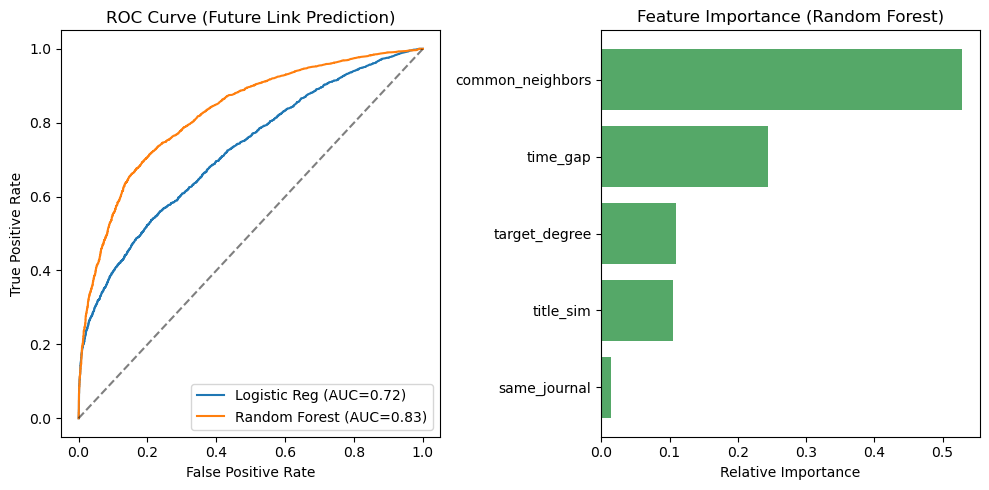


📝 Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.67      0.89      0.77      4343
           1       0.84      0.57      0.68      4343

    accuracy                           0.73      8686
   macro avg       0.76      0.73      0.72      8686
weighted avg       0.76      0.73      0.72      8686



In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, confusion_matrix
import seaborn as sns

# --- Phase 4: Model Training & Evaluation ---

def train_and_evaluate(X_train, y_train, X_test, y_test):
    """
    Trains models and evaluates performance on the future test set.
    """
    results = {}
    
    # 1. Logistic Regression (Baseline)
    print("🤖 Training Logistic Regression...")
    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_model.fit(X_train, y_train)
    
    lr_probs = lr_model.predict_proba(X_test)[:, 1]
    lr_auc = roc_auc_score(y_test, lr_probs)
    results['Logistic Regression'] = {'model': lr_model, 'auc': lr_auc, 'probs': lr_probs}
    
    print(f"   Logistic Regression AUC: {lr_auc:.4f}")
    
    # 2. Random Forest (Advanced)
    print("🌲 Training Random Forest...")
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf_model.fit(X_train, y_train)
    
    rf_probs = rf_model.predict_proba(X_test)[:, 1]
    rf_auc = roc_auc_score(y_test, rf_probs)
    results['Random Forest'] = {'model': rf_model, 'auc': rf_auc, 'probs': rf_probs}
    
    print(f"   Random Forest AUC:       {rf_auc:.4f}")
    
    # 3. Visualization
    plt.figure(figsize=(10, 5))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
    
    plt.plot(fpr_lr, tpr_lr, label=f'Logistic Reg (AUC={lr_auc:.2f})')
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={rf_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Future Link Prediction)')
    plt.legend()
    
    # Feature Importance (Random Forest)
    plt.subplot(1, 2, 2)
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)
    features = X_train.columns
    
    plt.barh(range(len(indices)), importances[indices], align='center', color='#55a868')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance (Random Forest)')
    
    plt.tight_layout()
    plt.show()
    
    # Detailed Report for Best Model (RF)
    print("\n📝 Classification Report (Random Forest):")
    y_pred_rf = (rf_probs > 0.5).astype(int)
    print(classification_report(y_test, y_pred_rf))
    
    return results

# Execute Phase 4
# Handle NaN values if any (simple imputation)
X_train_clean = X_train.fillna(0)
X_test_clean = X_test.fillna(0)

model_results = train_and_evaluate(X_train_clean, y_train, X_test_clean, y_test)

## Phase 5: Community Evolution (社区演化)

**目标**:
识别统计学领域的学术社区随时间的演变，发现新兴的研究热点。

**方法**:
1.  **Snapshot 1 ($G_{train}$)**: 检测历史社区结构 (Base Communities)。
2.  **Snapshot 2 ($G_{full}$)**: 检测当前社区结构 (Evolved Communities)。
3.  **Evolution Analysis**:
    *   对比社区数量变化。
    *   识别增长最快的社区（Emerging Communities）。
    *   提取新兴社区的核心论文（Top Degree within Community）。

In [14]:
# --- Phase 5: Community Evolution ---

def detect_and_analyze_communities(G, name="Graph"):
    """
    Detects communities using Louvain algorithm and returns stats.
    """
    print(f"🔍 Detecting communities for {name} ({G.number_of_nodes()} nodes)...")
    
    # Use NetworkX's built-in Louvain (requires nx >= 2.7)
    # We convert to undirected for stable community detection
    G_undirected = G.to_undirected()
    
    try:
        # Returns list of sets
        communities = nx.community.louvain_communities(G_undirected, seed=42)
    except AttributeError:
        print("   Note: nx.community.louvain_communities not found. Trying fallback...")
        # Fallback logic if needed, or just fail gracefully
        raise ImportError("Please upgrade networkx to >= 2.7 for Louvain support.")
        
    print(f"   Found {len(communities)} communities.")
    return communities

def analyze_evolution(comm_train, comm_full, G_full):
    """
    Analyzes how communities grew from Train to Full snapshot.
    """
    # 1. Basic Stats
    print("\n📈 Evolution Statistics:")
    print(f"   Historical Communities (Train): {len(comm_train)}")
    print(f"   Current Communities (Full):     {len(comm_full)}")
    
    # 2. Identify Largest/Emerging Communities in Full Graph
    # Sort by size
    sorted_comms = sorted(comm_full, key=len, reverse=True)
    
    print("\n🌟 Top 5 Active Communities (by Size):")
    for i, comm in enumerate(sorted_comms[:5]):
        # Get top papers in this community by Degree (in G_full)
        subgraph = G_full.subgraph(comm)
        # Calculate degree centrality within the subgraph
        local_degrees = dict(subgraph.degree())
        top_nodes = sorted(local_degrees.items(), key=lambda x: x[1], reverse=True)[:3]
        
        print(f"\n   Community #{i+1} (Size: {len(comm)} papers)")
        print(f"   Key Papers (Hubs):")
        for node_id, deg in top_nodes:
            # Fetch title if available
            node_data = G_full.nodes[node_id]
            title = node_data.get('title', 'Unknown Title')
            year = node_data.get('year', 'N/A')
            # Truncate title for display
            title_display = (title[:75] + '..') if isinstance(title, str) and len(title) > 75 else title
            print(f"     - [{int(year) if pd.notna(year) else 'N/A'}] {title_display} (Deg: {deg})")

# Execute Phase 5
try:
    comm_train = detect_and_analyze_communities(G_train, "Historical (Train)")
    comm_full = detect_and_analyze_communities(G_full, "Current (Full)")
    
    analyze_evolution(comm_train, comm_full, G_full)
    
except Exception as e:
    print(f"\n⚠️ Community Detection Skipped: {e}")
    print("Ensure networkx is up to date or install python-louvain.")

🔍 Detecting communities for Historical (Train) (4403 nodes)...
   Found 138 communities.
🔍 Detecting communities for Current (Full) (5096 nodes)...
   Found 138 communities.
🔍 Detecting communities for Current (Full) (5096 nodes)...
   Found 84 communities.

📈 Evolution Statistics:
   Historical Communities (Train): 138
   Current Communities (Full):     84

🌟 Top 5 Active Communities (by Size):

   Community #1 (Size: 520 papers)
   Key Papers (Hubs):
     - [2001] Variable selection via nonconcave penalized likelihood and its oracle prope.. (Deg: 238)
     - [2006] The adaptive lasso and its oracle properties (Deg: 165)
     - [2008] Sure independence screening for ultrahigh dimensional feature space (Deg: 114)

   Community #2 (Size: 449 papers)
   Key Papers (Hubs):
     - [2006] A distributional approach for causal inference using propensity scores (Deg: 23)
     - [2004] Design sensitivity in observational studies (Deg: 19)
     - [2009] Improving efficiency and robustness of the